In [1]:
def hist_match(source, reference):
    """
    Adjust the values of a source array
    so that its histogram matches that of a reference array
    """
    orig_shape = source.shape
    source = source.ravel()
    reference = reference.ravel()

    # get the set of unique pixel values
    # and their corresponding indices and counts
    s_values, s_idx, s_counts = np.unique(
        source, return_inverse=True, return_counts=True)
    r_values, r_counts = np.unique(reference, return_counts=True)

    # take the cumsum of the counts; empirical cumulative distribuition
    s_quantiles = np.cumsum(s_counts).astype(np.float64) / source.size
    r_quantiles = np.cumsum(r_counts).astype(np.float64) / reference.size

    # Create the lookup table,
    # find values in the reference corresponding to the quantiles in the source
    interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)

    # using the inverted source indicies, map to the interpolated pixel values
    # and reshape to the original array
    return interp_r_values[s_idx].reshape(orig_shape)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from pylab import rcParams

def plot_size(size):
    if size == "large":
        rcParams['figure.figsize'] = 10, 10
    elif size == "small":
        rcParams['figure.figsize'] = 7, 4
        
plot_size('large') 

def plot_cdfs(source, reference, target, plotname):
    plot_size('small')
    sv, sc = np.unique(source, return_counts=True)
    rv, rc = np.unique(reference, return_counts=True)
    tv, tc = np.unique(target, return_counts=True)

    scdf = np.cumsum(sc).astype(np.float64) / source.size
    rcdf = np.cumsum(rc).astype(np.float64) / reference.size
    tcdf = np.cumsum(tc).astype(np.float64) / target.size

    plt.title("{} empirical cumulative distribution".format(plotname))
    plt.plot(sv, scdf, label="Source")
    plt.plot(rv, rcdf, label="Reference")
    plt.plot(tv, tcdf, '--r', lw=2, label="Target")
    plt.legend(loc=5)
    plt.show()
    plot_size('large')


def show_tif(filename):
    pil_im = Image.open(filename, 'r')
    imshow(np.asarray(pil_im))

In [3]:
import rasterio
from rio_color.colorspace import ColorSpace as cs
from rio_color.colorspace import convert_arr
from skimage.color import rgb2lab, lab2rgb

def reshape_as_image(arr):
    """raster order (bands, rows, cols) -> image (rows, cols, bands)
    """
    return np.swapaxes(np.swapaxes(arr, 0, 2), 0, 1)


def reshape_as_raster(arr):
    """image order (rows, cols, bands) -> rasterio (bands, rows, cols)
    """
    return np.swapaxes(np.swapaxes(arr, 2, 0), 2, 1)


def cs_forward(arr, color):
    """ RGB (any dtype) to whatevs
    """
    arrnorm = arr.astype('float64') / np.iinfo(arr.dtype).max
    color = color.lower()
    
    #print(arrnorm.shape)
 
    if color == 'rgb':
        return arrnorm
    elif color == 'lch':
        return convert_arr(arrnorm, src=cs.rgb, dst=cs.lch)
    elif color == 'lab':
        img = reshape_as_image(arrnorm)
        lab = rgb2lab(img)
        return reshape_as_raster(lab)


def cs_backward(arr, color='rgb'):
    """whatevs to RGB 8-bit
    """
    color = color.lower()
    if color == 'rgb':
        return (arr * 255).astype('uint8')
    elif color == 'lch':
        rgb = convert_arr(arr, src = cs.lch, dst=cs.rgb)
        return (rgb * 255).astype('uint8')
    elif color == 'lab':
        lab = reshape_as_image(arr)
        rgb = lab2rgb(lab)
        rgbrast = reshape_as_raster(rgb)
        return (rgbrast * 255).astype('uint8')

In [9]:
#importing all tif images
import glob

images = []

for image_path in glob.iglob(image_dir + '**/*.tif', recursive=True):
    images.append(image_path)

Albuera_1_sat


In [10]:
# Load the source and reference
reference = ref_dir
lch_folder = lch_out
rgb_folder = rgb_out

for image in images:
    if image != reference:
        
        ############################### LCH ############################### 
        
        source = image

        with rasterio.open(source) as src:
            profile = src.profile.copy()
            profile['dtype'] = 'uint8'
            isinstance(profile['transform'], rasterio.Affine)
            src_arr = src.read()
        
        
        
        with rasterio.open(reference) as ref:
            ref_arr = ref.read()
            
        target_lch_path = lch_folder + "\\" + image.split("\\")[-1].split(".tif")[0] + "_LCH.tif"
        src_lch = cs_forward(src_arr, 'LCH')
        ref_lch = cs_forward(ref_arr, 'LCH')
        target_lch = src_lch.copy()
        
        # Replace Lightness and Chroma with the version
        # matched to the refernce histogram
        target_lch[0] = hist_match(src_lch[0], ref_lch[0])
        target_lch[1] = hist_match(src_lch[1], ref_lch[1])
        
        # Note: We don't match on the third band, HUE
        # - it's a radial measurement == discontinuous
        # - By matching only Lightness and Chroma, we can avoid Blood River
        # target_lch[2] = hist_match(src_lch[2], ref_lch[2])
        target_match_lch = cs_backward(target_lch, 'LCH')

        with rasterio.open(target_lch_path, 'w', **profile) as dst:
            dst.write(target_match_lch)
        
        src.closed
        ref.closed
        dst.closed
        
        ############################### RGB ############################### 
        
        target_rgb_path = rgb_folder + "\\" + image.split("\\")[-1].split(".tif")[0] + "_RGB.tif"

        src_rgb = cs_forward(src_arr, 'RGB')
        ref_rgb = cs_forward(ref_arr, 'RGB')

        target_rgb = src_rgb.copy()

        # Replace Red, Green and Blue with array
        # matched to the refernce histogram
        target_rgb[0] = hist_match(src_rgb[0], ref_rgb[0])
        target_rgb[1] = hist_match(src_rgb[1], ref_rgb[1])
        target_rgb[2] = hist_match(src_rgb[2], ref_rgb[2])

        target_match_rgb = cs_backward(target_rgb, 'RGB')


        with rasterio.open(target_rgb_path, 'w', **profile) as dst:
            dst.write(target_match_rgb)
            
        dst.closed
            
    else:
        pass

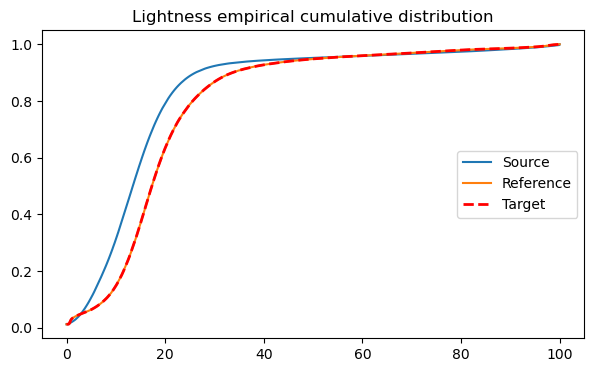

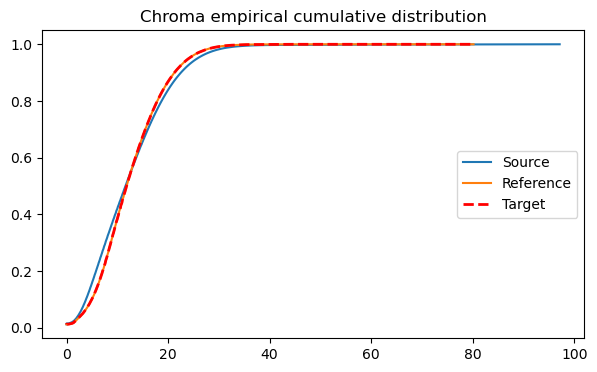

In [15]:
# plot the histograms
plot_cdfs(src_lch[0], ref_lch[0], target_lch[0], "Lightness")
plot_cdfs(src_lch[1], ref_lch[1], target_lch[1], "Chroma")

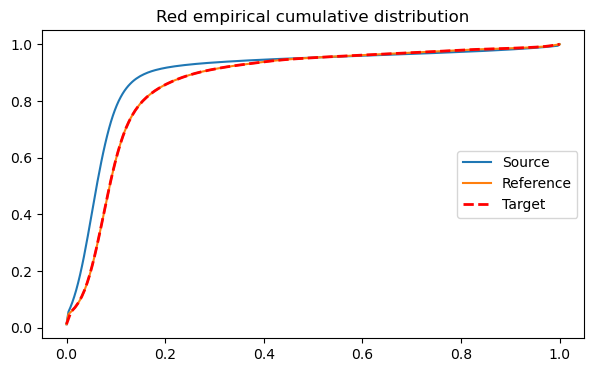

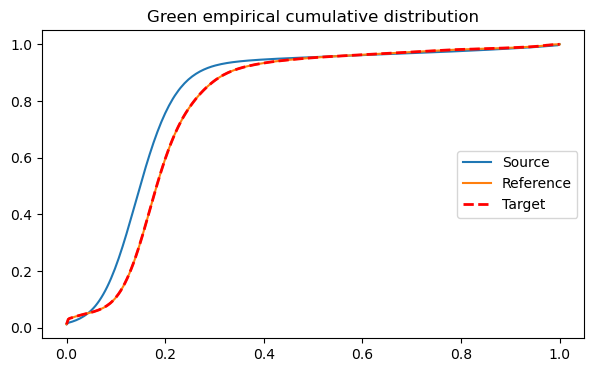

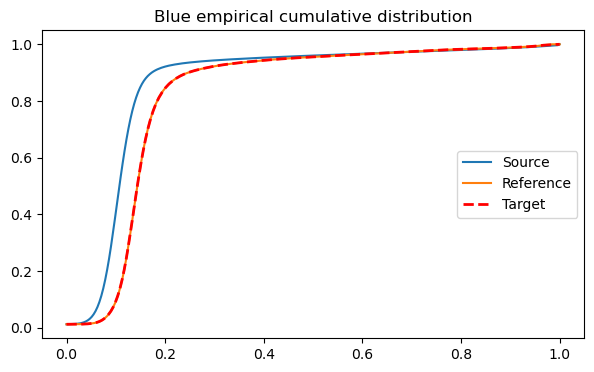

In [16]:
# plot the histograms
plot_cdfs(src_rgb[0], ref_rgb[0], target_rgb[0], "Red")
plot_cdfs(src_rgb[1], ref_rgb[1], target_rgb[1], "Green")
plot_cdfs(src_rgb[2], ref_rgb[2], target_rgb[2], "Blue")

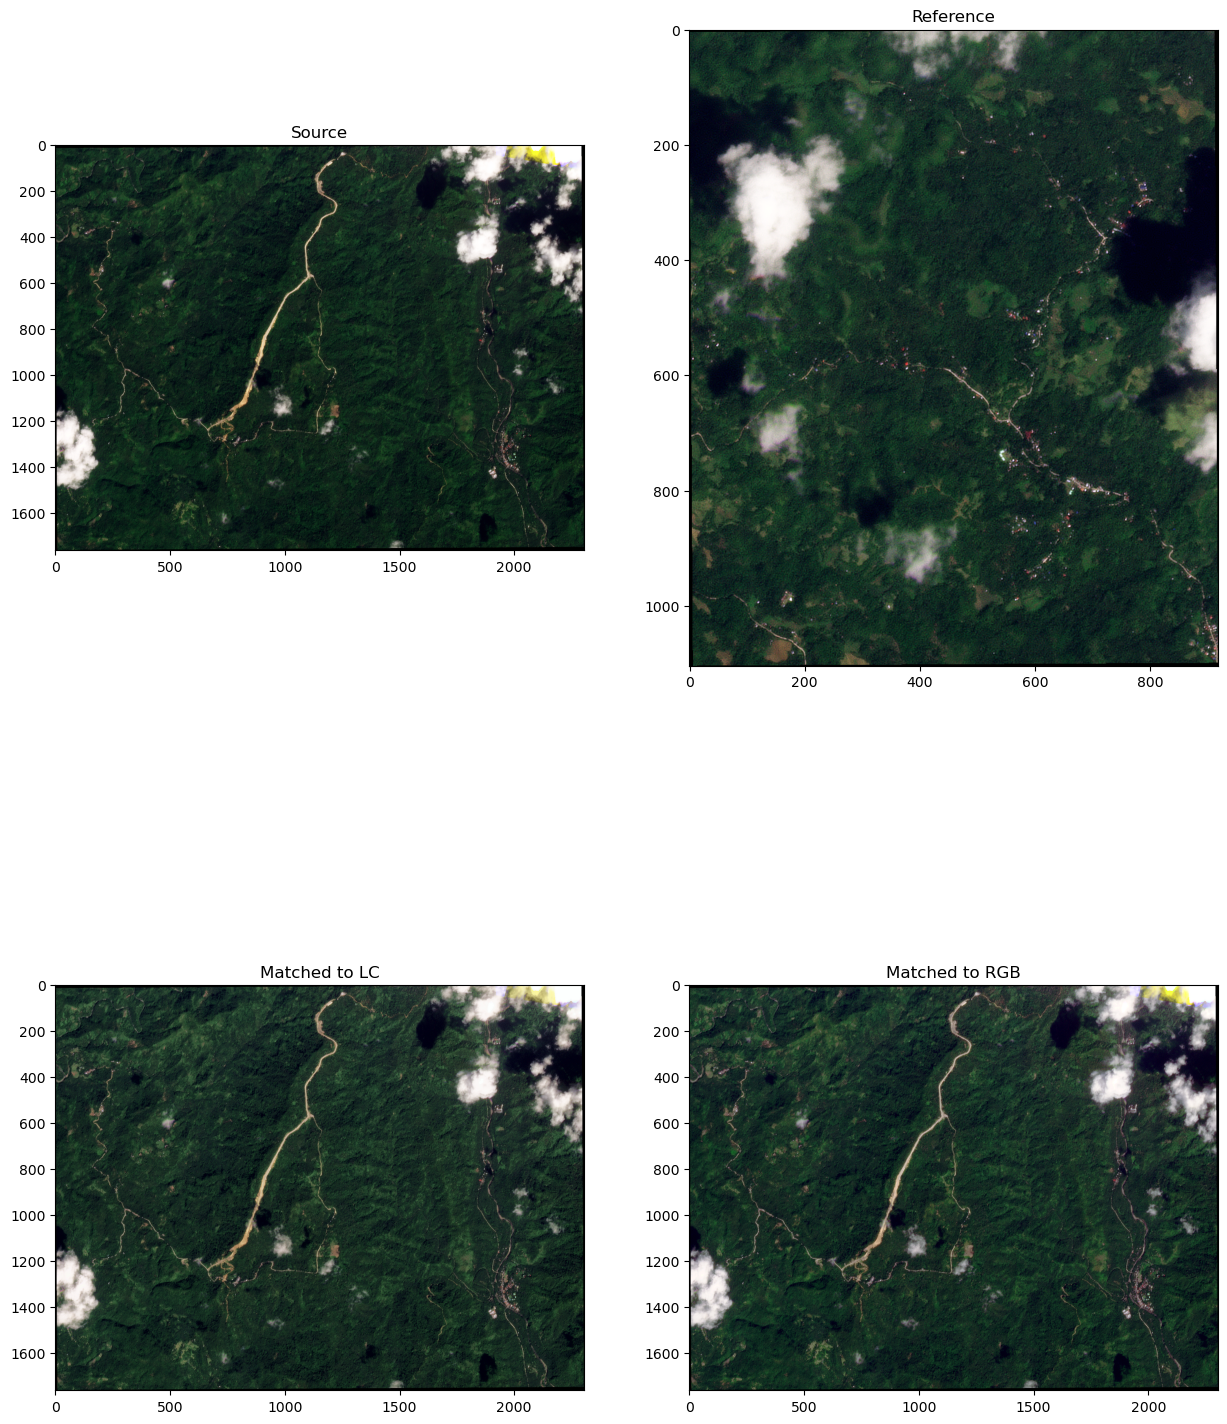

In [17]:
rcParams['figure.figsize'] = 15, 20
i1 = Image.open(source, 'r')
i2 = Image.open(reference, 'r')
i3 = Image.open(target_lch_path, 'r') 
i4 = Image.open(target_rgb_path, 'r') 

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.imshow(i1)
ax1.set_title('Source')
ax2.imshow(i2)
ax2.set_title('Reference')
ax3.imshow(i3)
ax3.set_title('Matched to LC')
ax4.imshow(i4)
ax4.set_title('Matched to RGB')
plt.show()

plot_size('large')